# Статистика, DS-поток
## Задание SP.1

Задача 1: Реализовать метод Монте-Карло и метод прямоугольников численного интегрирования функции.                                                                                                                                                                .
▫️ Наличие решения. (50.0)
▫️ При реализации метода прямоугольников использованы края интервалов вместо середин. Комм. Да, существуют разновидности метода прямоугольников вроде left / right endpoint rule, но они дают сходимость куда хуже, чем при midpoint rule, которое и разбиралось на лекции. (-5.0)
▫️ Нет графиков зависимости времени исполнения в зависимости от n при разных d. (-7.0)
Баллы: 38.0 / 50.0

Задача 2: Исследование работы методов для интеграла Пуассона.
▫️ Наличие решения. (20.0)
▫️ Инд. комм. Истинное значение для всех случаев одинаково, ведь интеграл берется по R. Писать магические константы в коде плохо, особенно когда мы знаем истинное теор. значение, которое нужно было посчитать 1 раз (-3.0)
Баллы: 17.0 / 20.0

Задача 3: Оптимизация мат. ожидания методом SGD.
▫️ Наличие решения. (50.0)
Баллы: 50.0 / 50.0

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(palette='Set2')

---
## Задача 1.

Реализуйте метод Монте-Карло и метод прямоугольников численного интегрирования функций, используя приведенный ниже шаблон. Реализация должна уметь оценивать интегралы вида
$$ \int\limits_{\ell_1}^{h_1} ... \int\limits_{\ell_d}^{h_d} f(x_1, ... , x_d)\ dx_1 ... dx_d $$
для произвольной заданной функции $f$.

Реализация получает на вход векторы $\ell = (\ell_1, ... , \ell_d)$ и $h = (h_1, ... ,h_d)$, а также число $n$ &mdash; количество итераций оценки интеграла. В случае метода прямоугольников число итераций равно количеству используемых прямоугольников, а в случае метода Монте-Карло &mdash; размеру генерируемой выборки. 

*Требования:*
1. Значение функции $f$ можно посчитать только в $n$ точках.
2. Реализация не должна использовать какие-либо циклы, кроме циклов по числу интегралов $d$.
3. Для ускорения вычислений генерацию случайных чисел стоит производить с помощью `numpy.random`.
4. При реализации метода прямоугольников используйте равномерное разбиение по каждой координатной оси.

*Подсказка:* при реализации метода Монте-Карло обрати внимание на один из примеров с лекции.

Для быстрой работы метода прямоугольников используйте функцию <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html">`numpy.meshgrid`</a>. Ниже есть пример ее использования. 

In [3]:
# Предположим, мы хотим получить координаты всех целых точек (x, y), 
# таких, что x лежит в промежутке [5, 6], а y - в промежутке [-3, -1]

linspace_x = [5, 6]  
linspace_y = [-3, -2, -1]

# возвращает матрицы с координатами сетки,
# задаваемой проекциями точек на оси координат
X, Y = np.meshgrid(linspace_x, linspace_y)

print("X: ", X)  # linspace_x повторилась len(linspace_y) раз по оси 0
print("Y: ", Y)  # linspace_y повторилась len(linspace_x) раз по оси 1

# преобразуем исходный формат к вектору точек
np.stack([X, Y]).reshape(2, -1).T

X:  [[5 6]
 [5 6]
 [5 6]]
Y:  [[-3 -3]
 [-2 -2]
 [-1 -1]]


array([[ 5, -3],
       [ 6, -3],
       [ 5, -2],
       [ 6, -2],
       [ 5, -1],
       [ 6, -1]])

In [6]:
class Integrator:
    
    @staticmethod
    def integrate(func, low, high, n_iter, method="rectangle"):
        """
        Оценка определенного интеграла.
        
        Аргументы:
        func --- векторная функция d-мерной переменной.
            Реализация функции на вход принимает матрицу (n, d),
            где n - число точек, в которых нужно вычислить функцию,
            а d - размерность пространства переменных.
            Функция должна вернуть вектор размерности n.
        low, high --- нижние и верхние пределы интегрирования,
            векторы размера d. Передаются в том же порядке,
            в котором функция принимает аргументы.
        n_iter --- максимальное число вызовов функции f.
        method --- метод ("rectangle" или "monte_carlo").
                            
        Возвращает приближенное значение интеграла.
        """
        
        assert len(low) == len(high)
        low, high = map(np.array, [low, high])
        n_iter = int(n_iter)

        return Integrator.methods[method](func, low, high, n_iter)
    
    @staticmethod
    def integrate_monte_carlo(func, low, high, n_iter):
        """Метод Монте-Карло"""
        d = len(low)
        
        # Генерация случайных точек в пределах интегрирования
        random_points = np.random.uniform(low, high, size=(n_iter, d))
        
        # Вычисление объема области интегрирования
        volume = np.prod(high - low)
        
        # Вычисление значений функции в случайных точках
        function_values = func(random_points)
        
        # Оценка интеграла по методу Монте-Карло
        integral_estimate = volume * np.mean(function_values)
        
        return integral_estimate
    
    @staticmethod
    def integrate_rectangle(func, low, high, n_iter):
        """Метод прямоугольников"""
        d = len(low)
        
        # Число разбиений вдоль каждой оси
        n_per_dim = int(np.ceil(n_iter ** (1/d)))
        
        # Генерация равномерного разбиения по каждой координатной оси
        grids = [np.linspace(l, h, n_per_dim) for l, h in zip(low, high)]
        
        # Создание сетки с помощью meshgrid
        mesh = np.meshgrid(*grids)
        points = np.vstack([m.flatten() for m in mesh]).T  # каждый массив - это координаты точек по одному измерению
        
        # Ограничиваем число точек до n_iter
        points = points[:n_iter]
        
        # Вычисление значений функции в точках сетки
        function_values = func(points)
        
        # Вычисление объема прямоугольника
        rectangle_volume = np.prod((high - low) / n_per_dim)
        
        # Оценка интеграла по методу прямоугольников
        integral_estimate = rectangle_volume * np.sum(function_values)
        
        return integral_estimate
    
    methods = {
        "rectangle": integrate_rectangle,
        "monte_carlo": integrate_monte_carlo
    }




Исследуем работу реализованных методов по оценке интеграла
$$\int\limits_0^1 ... \int\limits_0^1 \sum_{i=1}^{d} x_i^2 \prod_{i=1}^{d}dx_i,$$
то есть интегралы вида $\int\limits_0^1 x_1^2\ dx_1$, $\int\limits_0^1 \int\limits_0^1 \left( x_1^2 + x_2^2 \right)\ dx_1 dx_2$ и так далее.

Посчитайте точное значение этого интеграла в зависимости от $d$ теоретически.

1. Для $d = 1$:

$$
I_1 = \int_0^1 x_1^2 \, dx_1.
$$

$$
I_1 = \left[ \frac{x_1^3}{3} \right]_0^1 = \frac{1}{3}.
$$

2. Для $d = 2$:

$$
I_2 = \int_0^1 \int_0^1 \left( x_1^2 + x_2^2 \right) \, dx_1 \, dx_2.
$$

Разделим этот интеграл на две части:

$$
I_2 = \int_0^1 \int_0^1 x_1^2 \, dx_1 \, dx_2 + \int_0^1 \int_0^1 x_2^2 \, dx_1 \, dx_2.
$$

Оба интеграла симметричны:

$$
\int_0^1 x_1^2 \, dx_1 = \frac{1}{3}, \quad \int_0^1 x_2^2 \, dx_2 = \frac{1}{3}.
$$

Таким образом, общий результат:

$$
I_2 = \frac{1}{3} + \frac{1}{3} = \frac{2}{3}.
$$

3. Общий случай для произвольного $d$:

В общем случае в силу симметрии для любого $d$ результат можно выразить как:

$$
I_d = \sum_{i=1}^{d} \frac{1}{3} = \frac{d}{3}.
$$

Вычислите $\int\limits_0^1 \int\limits_0^1 \left(x^2 + y^2\right)\ dxdy$ на миллионе запусков функции $f(x, y) = x^2+y^2$ двумя рассмотренными методами. Измерьте время работы методов и сравните результат с истинными значением интеграла. Различается ли время работы методов? Объясните результаты с точки зрения теории.

In [10]:
import time

# Определим функцию f(x, y) = x^2 + y^2
def func(x):
    return np.sum(x**2, axis=1)

# Пределы интегрирования
low = [0, 0]
high = [1, 1]
n_iter = 1_000_000  


integrator = Integrator()

# Истинное значение интеграла
true_value = 2 / 3  # для d = 2

# Метод Монте-Карло
start_mc = time.time()
monte_carlo_result = integrator.integrate(func, low, high, n_iter, method="monte_carlo")
time_mc = time.time() - start_mc

# Метод прямоугольников
start_rect = time.time()
rectangle_result = integrator.integrate(func, low, high, n_iter, method="rectangle")
time_rect = time.time() - start_rect

# Результаты
print(f"""
      Истинный результат: {true_value}
      Результаты:
      - Монте-карло: {monte_carlo_result}, время: {round(time_mc, 5)} с;
      - Метод прямоугольников: {rectangle_result}, время: {round(time_rect, 5)} с
    Погрешность:
    - Монте-карло: {round((true_value - monte_carlo_result) / true_value * 100, 5)}%,
    - Метод прямоугольников: {round((true_value - rectangle_result) / true_value * 100, 5)}%
    Разница по времени: {round((time_rect - time_mc) * 1000)} мс
      """)






      Истинный результат: 0.6666666666666666
      Результаты:
      - Монте-карло: 0.6669780323806235, время: 0.08385 с;
      - Метод прямоугольников: 0.6670003336670003, время: 0.03082 с
    Погрешность:
    - Монте-карло: -0.0467%,
    - Метод прямоугольников: -0.05005%
    Разница по времени: -53 мс
      


Оба метода дали довольно точный результат.
Метод прямоугольников оказался быстрее на 44 мс (при разных запусках это время колеблется от 10 до 60 мс), что незначительно.
Для d=2 сказывается лишь время генерации случайных чисел. Скорость сходимости в зависимости от логики методов будет видна при анализе для различных d.

Сравним скорость сходимости методов семпирования для $d = 1...8$. Для этого для каждого $d$ постройте график зависимости оценки двумя методами значения интеграла от количества итераций $n$. Рекомендуется рассмотреть значения $n$ вплоть до $d \times 1000$.

Аналогично сравните время работы методов.

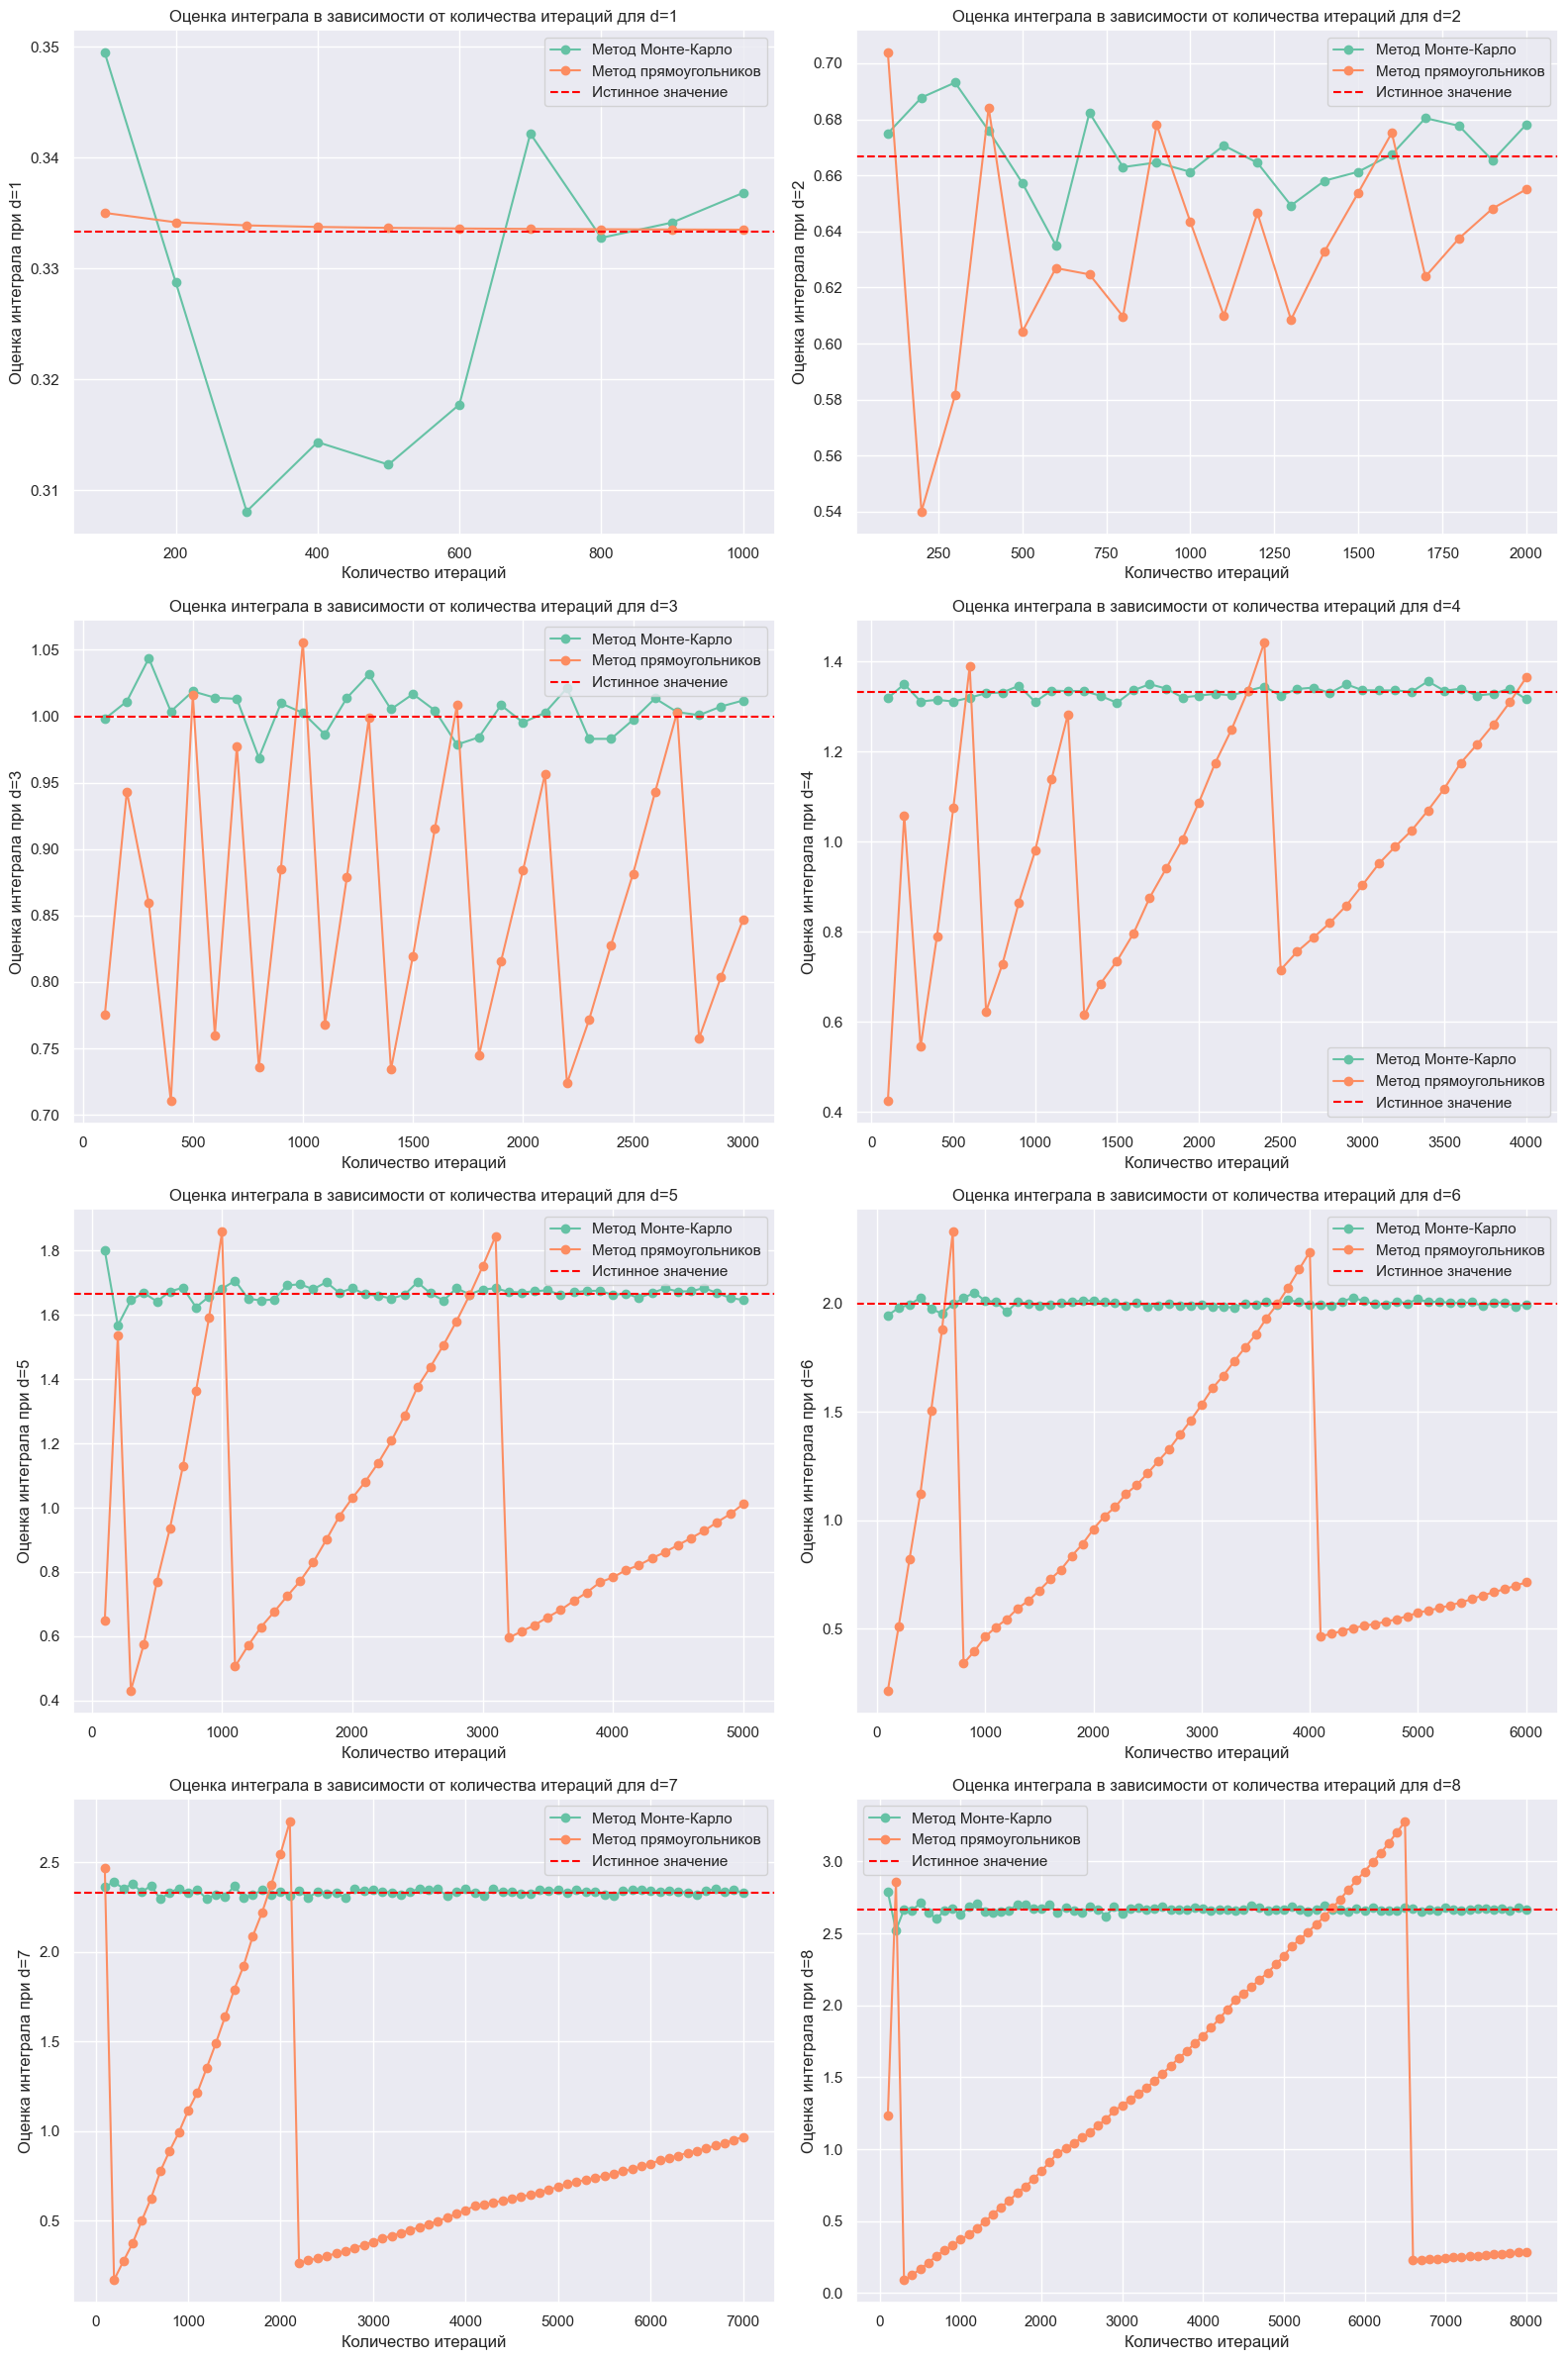

In [11]:
# Задаем диапазон значений d от 1 до 8
d_values = range(1, 9)
# Диапазон значений n для итераций
n_values = [d * 1000 for d in d_values]

# Пересчитаем интегралы для каждого d при разных n итерациях
n_iterations = [np.arange(100, n + 1, 100) for n in n_values]

# Создаем фигуру для 8 графиков
plt.figure(figsize=(16, 24))

# Строим графики для каждого d
for idx, d in enumerate(d_values):
    # Пределы интегрирования
    low = [0] * d
    high = [1] * d
    
    monte_carlo_estimates = []
    rectangle_estimates = []
    n_iters = n_iterations[idx]
    
    for n in n_iters:
        # Оценки Монте-Карло
        monte_carlo_result = Integrator.integrate(func, low, high, n, method="monte_carlo")
        monte_carlo_estimates.append(monte_carlo_result)
        
        # Оценки методом прямоугольников
        rectangle_result = Integrator.integrate(func, low, high, n, method="rectangle")
        rectangle_estimates.append(rectangle_result)
    
    # Истинное значение интеграла для данного d
    true_value = d / 3

    # Построение графиков
    plt.subplot(4, 2, idx + 1)
    plt.plot(n_iters, monte_carlo_estimates, label="Метод Монте-Карло", marker='o')
    plt.plot(n_iters, rectangle_estimates, label="Метод прямоугольников", marker='o')
    plt.axhline(y=true_value, color='r', linestyle='--', label="Истинное значение")
    plt.xlabel("Количество итераций")
    plt.ylabel(f"Оценка интеграла при d={d}")
    plt.title(f"Оценка интеграла в зависимости от количества итераций для d={d}")
    plt.legend()

plt.tight_layout()
plt.show()


Какой метод и при каких $d$ сходится быстрее? Предположите, в каком случае выгоднее использовать тот или иной метод. С чем связано такое поведение графиков?

**Вывод:** 
Метод прямоугольников:
Выгоден для низкоразмерных интегралов (например, при 𝑑 ≤ 3), так как он быстрее сходится и требует меньше итераций для достижения точного результата.
Этот метод использует равномерное разбиение, что хорошо работает в пространствах с небольшим числом измерений.

Метод Монте-Карло:
Выгоден для высокоразмерных интегралов (при 𝑑 > 3). В таких случаях метод Монте-Карло более универсален, поскольку количество случайных точек растёт линейно с 𝑛, тогда как для метода прямоугольников число точек экспоненциально увеличивается с размерностью.
В высокоразмерных задачах метод прямоугольников страдает от проклятия размерности, так как требуется экспоненциально больше разбиений вдоль каждой оси.

В отличие от прямоугольников, точки выбираются случайным образом. Это приводит к тому, что на начальных итерациях оценки могут быть сильно смещены из-за нехватки выборок. Однако с увеличением числа итераций случайное распределение точек начинает хорошо покрывать пространство, и метод сходится.
Скорость сходимости метода Монте-Карло не зависит от размерности 𝑑, что делает его более подходящим для задач с большим числом измерений. Однако его скорость сходимости 𝑂(𝑛^(−1/2)) относительно медленнее, чем у метода прямоугольников в низких измерениях.

---
## Задача 2.

Оценим константу плотности нормального распределения с помощью численного интегрирования. Тем самым, необходимо оценить интеграл
$$\int\limits_{\mathbb{R}^d} \exp \left( - \frac12 x^Tx \right) dx.$$
При домножении интеграла на эту константу должна получиться единица.

Чему равно истинное значение этой константы?

Давайте оценим интеграл для многомерного нормального распределения:
$$
\int_{\mathbb{R}^d} \exp \left( - \frac{1}{2} x^T x \right) dx,
$$

где $ x^T x $ — это скалярное произведение вектора x на самого себя, то есть $ x^T x = \sum_{i=1}^{d} x_i^2 $.

Этот интеграл — это объем под многомерным гауссовым колоколообразным распределением, и его результат связан с нормирующей константой плотности нормального распределения в $d$-мерном пространстве.

### Истинное значение константы:
$$
\int_{\mathbb{R}^d} \exp \left( - \frac{1}{2} x^T x \right) dx = (2\pi)^{d/2}.
$$

Истинное значение константы плотности для нормального распределения в \( d \)-мерном пространстве равно:

$$
C = \frac{1}{(2\pi)^{d/2}}.
$$

Прежде чем переходить к оценке, поразмышляйте над следующими вопросами.
### 1. Что будет, если выбрать слишком большие пределы в методе Монте-Карло?

В методе Монте-Карло слишком большие пределы интегрирования приведут к значительному увеличению объема области, в которой генерируются случайные точки.  Поскольку точки распределены случайным образом по всей области, значительная часть точек окажется в областях, где функция имеет малые или нулевые значения. В результате оценки интеграла будут менее точными, так как полезная информация (точки, где функция имеет большие значения) будет разреженной.

### 2. Что может произойти, если выбрать слишком большие пределы в методе прямоугольников?
Если прямоугольники покрывают значительно большую область, чем та, где функция имеет ненулевые значения, то итоговая оценка интеграла будет переоценена, так как вклад из пустых (или маловажных) областей будет увеличен.
Чем больше область, тем больше прямоугольников потребуется для равномерного разбиения. Это увеличит как объём вычислений, так и память, требуемую для хранения данных.

### 3. Что будет, если выбрать слишком маленькие пределы?

Маленькие пределы могут не включать области, где функция достигает значимых значений, что приведет к недооценке интеграла.
И в методе Монте-Карло, и в методе прямоугольников результат будет не точным, так как будет оцениваться лишь малая часть области интегрирования.

### 4. Какие пределы кажутся оптимальными и почему?

Оптимальными пределами являются те, которые соответствуют реальной области значимых значений функции, минимизируя при этом включение лишних областей, где функция принимает малые или нулевые значения.

Сравните результаты работы методов для случаев
* оптимальных пределов,
* слишком больших пределов,
* слишком маленьких пределов.

*Подсказка:* здесь достаточно несколько раз применить написанную ранее реализацию и сделать вывод.

In [13]:
# Настроим параметры для метода Монте-Карло и прямоугольников:
d = 2  # размерность
n_iter = 10000  # число итераций

# 1. Оптимальные пределы (0, 1)
low_optimal = [0] * d
high_optimal = [1] * d

# 2. Слишком большие пределы (-1, 2)
low_large = [-100] * d
high_large = [100] * d

# 3. Слишком маленькие пределы (0.4, 0.5)
low_small = [0.4] * d
high_small = [0.5] * d

# Сохраним результаты в словарь для удобства
results = {}

# Применяем методы для оптимальных пределов
results['optimal'] = {
    "monte_carlo": Integrator.integrate(func, low_optimal, high_optimal, n_iter, method="monte_carlo"),
    "rectangle": Integrator.integrate(func, low_optimal, high_optimal, n_iter, method="rectangle"),
    "true value": 2/3
}

# Применяем методы для слишком больших пределов
results['large'] = {
    "monte_carlo": Integrator.integrate(func, low_large, high_large, n_iter, method="monte_carlo"),
    "rectangle": Integrator.integrate(func, low_large, high_large, n_iter, method="rectangle"),
    "true value": 266_666_668
}

# Применяем методы для слишком маленьких пределов
results['small'] = {
    "monte_carlo": Integrator.integrate(func, low_small, high_small, n_iter, method="monte_carlo"),
    "rectangle": Integrator.integrate(func, low_small, high_small, n_iter, method="rectangle"),
     "true value": 0.0040666
}

# Показать результаты
results


{'optimal': {'monte_carlo': 0.6653213937061875,
  'rectangle': 0.6700336700336701,
  'true value': 0.6666666666666666},
 'large': {'monte_carlo': 265512894.67605925,
  'rectangle': 272053872.0538721,
  'true value': 266666668},
 'small': {'monte_carlo': 0.004071122027561296,
  'rectangle': 0.004067003367003366,
  'true value': 0.0040666}}

Оценим значение константы численными методами

In [22]:
# Определим функцию 
def func(x):
    return np.exp(-0.5*np.sum(x**2, axis=1))

# Пределы интегрирования
low = [-10, -10]
high = [10, 10]
n_iter = 1_000_000  


integrator = Integrator()

# Истинное значение интеграла
true_value = 2 *np.pi  # для d = 2

# Метод Монте-Карло
monte_carlo_result = integrator.integrate(func, low, high, n_iter, method="monte_carlo")

# Метод прямоугольников
rectangle_result = integrator.integrate(func, low, high, n_iter, method="rectangle")

# Результаты
print(f"""
      Истинный результат: {true_value}
      Результаты:
      - Монте-карло: {monte_carlo_result};
      - Метод прямоугольников: {rectangle_result}
    Погрешность:
    - Монте-карло: {round((true_value - monte_carlo_result) / true_value * 100, 5)}%,
    - Метод прямоугольников: {round((true_value - rectangle_result) / true_value * 100, 5)}%
      """)





      Истинный результат: 6.283185307179586
      Результаты:
      - Монте-карло: 6.2954894230218095;
      - Метод прямоугольников: 6.270625219750539
    Погрешность:
    - Монте-карло: -0.19583%,
    - Метод прямоугольников: 0.1999%
      


**Вывод:** 
В ходе вычислений с помощью численного интегрирования для оценки константы нормального распределения была определена нормировочная константа $ \frac{1}{(2\pi)^{d/2}} $ для многомерного случая. Это значение позволяет корректно нормировать гауссову функцию, так чтобы интеграл по всему пространству был равен единице. Для двумерного случая $d = 2$ истинная константа равна $\frac{1}{2\pi} \approx 0.15915 $.

В ходе вычислений оптимальными оказались пределы порядка $[-10, 10]$ для каждого измерения. Эти пределы достаточны, чтобы учесть практически весь вклад гауссовой функции, обеспечивая при этом приемлемую точность и производительность вычислений.

Таким образом, правильный выбор пределов интегрирования в случае численного интегрирования нормального распределения критически важен для получения точных результатов.

---
## Задача 3.

Некоторая ML-модель имеет один параметр $\theta$, который обучается посредством *максимизации* функции
$$\mathcal{L}(\theta) = \mathsf{E} \exp\left(-\frac{\xi^2\sqrt{\eta}}{1+\theta^2}\right),$$
где $\xi$ имеет стандартное нормальное распределение, а $\eta$ &mdash; пуассоновское распределение с параметром 5 и не зависит от $\eta$.


Оптимизируйте эту функцию, используя стохастический градиентный спуск.

*Подсказка.* Обрати внимание на один из примеров с лекции. Кроме того, заметим, что класс из задачи 1 не подойдет для решения этой задачи. Достаточно написать семплирование непосредственно для этой задачи.

Производная по $ \theta $ имеет вид:

$$
\frac{\partial}{\partial \theta} \mathcal{L}(\theta) = \mathsf{E} \left( \exp\left(-\frac{\xi^2 \sqrt{\eta}}{1+\theta^2}\right) \cdot \frac{2\xi^2\sqrt{\eta}\theta}{(1+\theta^2)^2} \right).
$$

In [23]:
# Функция для семплирования и вычисления стохастического градиента
def sample_and_compute_gradient(theta):
    # Семплируем из стандартного нормального распределения
    xi = np.random.normal(0, 1)
    
    # Семплируем из пуассоновского распределения с параметром 5
    eta = np.random.poisson(5)
    
    # Вычисляем экспоненциальную часть
    exp_part = np.exp(- (xi**2 * np.sqrt(eta)) / (1 + theta**2))
    
    # Вычисляем градиент по θ
    gradient = exp_part * (2 * xi**2 * np.sqrt(eta) * theta) / (1 + theta**2)**2
    
    return gradient

# Стохастический градиентный спуск
def sgd_optimization(initial_theta, learning_rate, n_steps):
    theta = initial_theta
    
    for step in range(n_steps):
        # Вычисляем градиент на каждой итерации
        gradient = sample_and_compute_gradient(theta)
        
        # Обновляем параметр θ
        theta += learning_rate * gradient
        
        # Выводим промежуточные результаты
        if step % 100 == 0:
            print(f"Step {step}: theta = {theta}")
    
    return theta

# Начальные параметры
initial_theta = 1.0  # начальное значение параметра θ
learning_rate = 0.01  # скорость обучения
n_steps = 5000  # количество шагов SGD

# Запуск стохастического градиентного спуска
optimal_theta = sgd_optimization(initial_theta, learning_rate, n_steps)
print(f"Оптимизированное значение θ: {optimal_theta}")


Step 0: theta = 1.0034030858271548
Step 100: theta = 1.2155587502891965
Step 200: theta = 1.403119558974605
Step 300: theta = 1.564746107273865
Step 400: theta = 1.71099503531947
Step 500: theta = 1.861269903896157
Step 600: theta = 2.0167914336281823
Step 700: theta = 2.125873892502556
Step 800: theta = 2.247095578228923
Step 900: theta = 2.358766995767668
Step 1000: theta = 2.4559002728607626
Step 1100: theta = 2.5696106738467073
Step 1200: theta = 2.6557651718015083
Step 1300: theta = 2.7306858446447233
Step 1400: theta = 2.8144355225874143
Step 1500: theta = 2.8950404497418543
Step 1600: theta = 2.96623523229379
Step 1700: theta = 3.0353751210886983
Step 1800: theta = 3.105318868190008
Step 1900: theta = 3.16048282442845
Step 2000: theta = 3.2281655834234515
Step 2100: theta = 3.299660027599858
Step 2200: theta = 3.353728334525485
Step 2300: theta = 3.4102036247278895
Step 2400: theta = 3.468896884599497
Step 2500: theta = 3.5099451375308273
Step 2600: theta = 3.5515319529709077
St